In [1]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from tensorflow.keras.models import Model


In [2]:
# Define your data directories, batch size, and other hyperparameters
train_dir = 'final_dataset/train'
val_dir = 'final_dataset/validation'
test_dir = 'final_dataset/test'
input_shape = (224, 224, 3)
num_classes = 101
num_epochs = 30

In [3]:


# Set the paths to your train, test, and validation directories
train_dir = "final_dataset/train"
test_dir = "final_dataset/test"
val_dir = "final_dataset/validation"

# Define the image size and number of classes
image_size = (224, 224)
num_classes = 101

# Create data generators with data augmentation for the train set
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=32,
    class_mode="categorical"
)

# Create data generators for the test and validation sets (no data augmentation)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=32,
    class_mode="categorical",
    shuffle=False  # Do not shuffle test data for evaluation
)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=32,
    class_mode="categorical"
)


Found 75750 images belonging to 101 classes.
Found 15150 images belonging to 101 classes.
Found 10100 images belonging to 101 classes.


In [4]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,  # Exclude the top (output) layer
    weights='imagenet',  # Load pre-trained weights
    input_shape=(224, 224, 3)  # Specify input shape
)

# Freeze the pre-trained layers (do not train them)
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# Create the fine-tuned model
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)


2023-11-03 05:04:36.313406: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-03 05:04:36.935815: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:222] Using CUDA malloc Async allocator for GPU: 0
2023-11-03 05:04:36.935955: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 25847 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:bd:00.0, compute capability: 8.0


In [5]:
# Compile the model 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_e

 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )        

 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_s

 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_d

 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_e

 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
          

In [7]:
# Define callbacks
checkpoint_callback = ModelCheckpoint(
    'efficient_transfer_learning_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

early_stopping_callback = EarlyStopping(
    monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

In [8]:
import time
start_time = time.time()

In [9]:
# Train the model
history = model.fit(
        train_generator,
        epochs=num_epochs,
        validation_data=val_generator,
        callbacks=[checkpoint_callback, early_stopping_callback]
)


Epoch 1/30


2023-11-03 05:04:44.114802: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8500


   2/2368 [..............................] - ETA: 4:38 - loss: 4.7213 - accuracy: 0.0000e+00   

2023-11-03 05:04:44.848877: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2368/2368 [==============================] - ETA: 0s - loss: 2.6783 - accuracy: 0.4011
Epoch 1: val_loss improved from inf to 1.78452, saving model to efficient_transfer_learning_model.h5
2368/2368 [==============================] - 687s 288ms/step - loss: 2.6783 - accuracy: 0.4011 - val_loss: 1.7845 - val_accuracy: 0.5566
Epoch 2/30
2368/2368 [==============================] - ETA: 0s - loss: 1.7806 - accuracy: 0.5536
Epoch 2: val_loss improved from 1.78452 to 1.53683, saving model to efficient_transfer_learning_model.h5
2368/2368 [==============================] - 680s 287ms/step - loss: 1.7806 - accuracy: 0.5536 - val_loss: 1.5368 - val_accuracy: 0.6062
Epoch 3/30
2368/2368 [==============================] - ETA: 0s - loss: 1.6037 - accuracy: 0.5901
Epoch 3: val_loss improved from 1.53683 to 1.42699, saving model to efficient_transfer_learning_model.h5
2368/2368 [==============================] - 684s 289ms/step - loss: 1.6037 - accuracy: 0.5901 - val_loss: 1.4270 - val_accuracy: 0.

Epoch 26/30
2368/2368 [==============================] - ETA: 0s - loss: 1.0382 - accuracy: 0.7201
Epoch 26: val_loss did not improve from 1.14677
2368/2368 [==============================] - 687s 290ms/step - loss: 1.0382 - accuracy: 0.7201 - val_loss: 1.1518 - val_accuracy: 0.6990
Epoch 27/30
2368/2368 [==============================] - ETA: 0s - loss: 1.0303 - accuracy: 0.7200
Epoch 27: val_loss improved from 1.14677 to 1.14573, saving model to efficient_transfer_learning_model.h5
2368/2368 [==============================] - 684s 289ms/step - loss: 1.0303 - accuracy: 0.7200 - val_loss: 1.1457 - val_accuracy: 0.7021
Epoch 28/30
2368/2368 [==============================] - ETA: 0s - loss: 1.0162 - accuracy: 0.7245
Epoch 28: val_loss improved from 1.14573 to 1.14326, saving model to efficient_transfer_learning_model.h5
2368/2368 [==============================] - 683s 289ms/step - loss: 1.0162 - accuracy: 0.7245 - val_loss: 1.1433 - val_accuracy: 0.7045
Epoch 29/30
2368/2368 [=========

In [10]:
end_time = time.time()
training_time = end_time - start_time
print(f"Total training time: {training_time:.2f} seconds")

Total training time: 20501.37 seconds


In [11]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2%}")

474/474 [==============================] - 25s 52ms/step - loss: 1.1521 - accuracy: 0.7007
Test Loss: 1.1521
Test Accuracy: 70.07%


In [12]:
# Calculate metrics
test_generator.reset()
predictions = model.predict(test_generator)
y_pred = [tf.argmax(pred).numpy() for pred in predictions]
y_true = test_generator.classes

474/474 [==============================] - 26s 52ms/step


In [13]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_true, y_pred)))
print("F1 Score: {:.2f}".format(f1_score(y_true, y_pred, average='macro')))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Classification Report:
                         precision    recall  f1-score   support

              apple_pie       0.46      0.54      0.49       150
         baby_back_ribs       0.64      0.71      0.68       150
                baklava       0.71      0.75      0.73       150
         beef_carpaccio       0.81      0.65      0.72       150
           beef_tartare       0.85      0.52      0.64       150
             beet_salad       0.51      0.66      0.58       150
               beignets       0.82      0.81      0.81       150
               bibimbap       0.78      0.89      0.83       150
          bread_pudding       0.58      0.43      0.49       150
      breakfast_burrito       0.65      0.74      0.69       150
             bruschetta       0.56      0.64      0.60       150
           caesar_salad       0.71      0.80      0.75       150
                cannoli       0.74      0.76      0.75       150
          caprese_salad       0.72      0.67      0.69       150
 

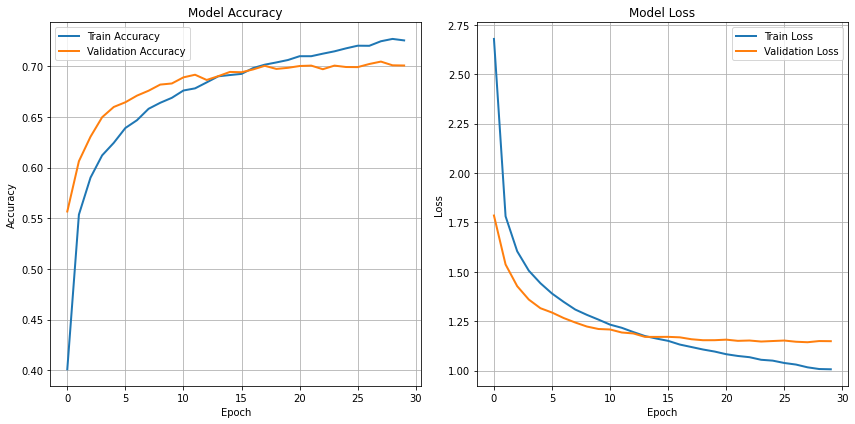

In [14]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
